In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as run

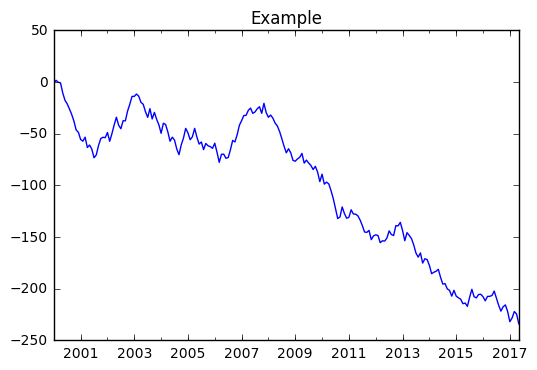

In [10]:
random.seed(100)
rng = pd.date_range(start='2000', periods =209,freq='M')
ts = pd.Series(np.random.uniform(-10,10,size=len(rng)),rng).cumsum()
ts.plot(c='b', title="Example")
plt.show()

In [11]:
ts.head(10)

2000-01-31    -0.871618
2000-02-29     1.733038
2000-03-31    -0.144302
2000-04-30    -0.784137
2000-05-31   -10.514862
2000-06-30   -17.585199
2000-07-31   -21.067725
2000-08-31   -26.027952
2000-09-30   -31.306954
2000-10-31   -37.789975
Freq: M, dtype: float64

In [12]:
TS = np.array(ts)
num_periods = 20  # 10 batches , 20 values per batch
f_horizon = 1  # Forecast Horizon, 1 period into future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]    #x_data len is truncated from 209 to 200
x_batches = x_data.reshape(-1,20,1)

y_data = TS[1:(len(TS)-len(TS) % num_periods)+f_horizon]
y_batches = y_data.reshape(-1,20,1)


print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:1])

print(y_batches.shape)
print(y_batches[0:1])


10
(10, 20, 1)
[[[ -0.87161837]
  [  1.73303777]
  [ -0.1443017 ]
  [ -0.78413731]
  [-10.51486174]
  [-17.58519857]
  [-21.06772526]
  [-26.0279521 ]
  [-31.30695353]
  [-37.78997547]
  [-46.29715964]
  [-48.60984149]
  [-55.51378377]
  [-57.15812431]
  [-53.31313975]
  [-63.26777656]
  [-60.89195221]
  [-64.86697844]
  [-73.21436214]
  [-70.43985332]]]
(10, 20, 1)
[[[  1.73303777]
  [ -0.1443017 ]
  [ -0.78413731]
  [-10.51486174]
  [-17.58519857]
  [-21.06772526]
  [-26.0279521 ]
  [-31.30695353]
  [-37.78997547]
  [-46.29715964]
  [-48.60984149]
  [-55.51378377]
  [-57.15812431]
  [-53.31313975]
  [-63.26777656]
  [-60.89195221]
  [-64.86697844]
  [-73.21436214]
  [-70.43985332]
  [-61.38727837]]]


In [13]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods+forecast):]
    testX = test_x_setup[:num_periods].reshape(-1,20,1)
    testY = TS[-(num_periods):].reshape(-1,20,1)
    return testX, testY

In [14]:
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)
print(Y_test.shape)
print(Y_test)

(1, 20, 1)
[[[-207.68351148]
  [-208.85526283]
  [-205.51468688]
  [-205.31546849]
  [-207.66917677]
  [-211.66580207]
  [-207.32227974]
  [-207.33190601]
  [-206.48869992]
  [-202.26520632]
  [-209.31866162]
  [-216.04988476]
  [-221.60421421]
  [-217.37786065]
  [-215.61752647]
  [-221.99492474]
  [-231.85970961]
  [-228.21572031]
  [-222.0523711 ]
  [-224.36089836]]]
(1, 20, 1)
[[[-208.85526283]
  [-205.51468688]
  [-205.31546849]
  [-207.66917677]
  [-211.66580207]
  [-207.32227974]
  [-207.33190601]
  [-206.48869992]
  [-202.26520632]
  [-209.31866162]
  [-216.04988476]
  [-221.60421421]
  [-217.37786065]
  [-215.61752647]
  [-221.99492474]
  [-231.85970961]
  [-228.21572031]
  [-222.0523711 ]
  [-224.36089836]
  [-233.94259247]]]


In [15]:
tf.reset_default_graph()

num_periods = 20  #number of periods per vector used to predict one period ahead
inputs = 1        #number of vectors submitted 
hidden = 100      #number of neurons we will recursively work through
output = 1        #number of output vector

X = tf.placeholder(tf.float32, [None, num_periods, inputs ])
y = tf.placeholder(tf.float32, [None, num_periods, output ])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)   # dynamic instead of static

learning_rate =0.001

stacked_rnn_output = tf.reshape(rnn_output,[-1, hidden])     # changed the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)  # GD
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()




In [20]:
epochs = 2000

with tf.Session() as sess:
    init.run()
    for i in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y:y_batches})
        if i % 100 == 0:
            mse = loss.eval(feed_dict={X:x_batches, y:y_batches})
            print(i, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)
        


0 	MSE: 2.76578e+06
100 	MSE: 42024.4
200 	MSE: 10928.6
300 	MSE: 3509.62
400 	MSE: 2710.62
500 	MSE: 2103.89
600 	MSE: 1725.4
700 	MSE: 2256.36
800 	MSE: 1574.84
900 	MSE: 1506.83
1000 	MSE: 1214.9
1100 	MSE: 1433.79
1200 	MSE: 1110.51
1300 	MSE: 1024.03
1400 	MSE: 1074.24
1500 	MSE: 1038.26
1600 	MSE: 871.019
1700 	MSE: 811.501
1800 	MSE: 1118.8
1900 	MSE: 805.432
[[[-211.68717957]
  [-213.33222961]
  [-206.18629456]
  [-200.10148621]
  [-210.56443787]
  [-201.58239746]
  [-198.94277954]
  [-210.91065979]
  [-198.94691467]
  [-196.60539246]
  [-213.05787659]
  [-213.64009094]
  [-217.00045776]
  [-229.42658997]
  [-204.11032104]
  [-227.14161682]
  [-255.65412903]
  [-203.80943298]
  [-225.26126099]
  [-258.49328613]]]


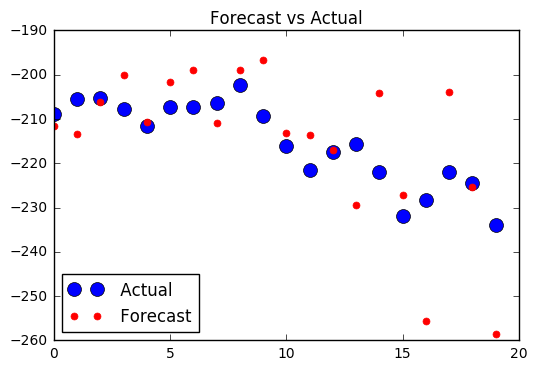

In [21]:
plt.title("Forecast vs Actual")

plt.plot(pd.Series(np.ravel(Y_test)),"bo", markersize=10, label =" Actual")
plt.plot(pd.Series(np.ravel(y_pred)),"r.", markersize=10, label =" Forecast")
plt.legend(loc="lower left")

plt.show()